In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from skimage import data, img_as_float
from skimage import exposure
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import tqdm
from sklearn.neighbors import KernelDensity


from tqdm import tqdm
from collections import Counter

import os
import sys
sys.path.append(os.path.abspath('../skin-lesion-cad'))

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from utils import dice
import click


class Segment:

    def FindPoint(self, x1, y1, x2, y2, x, y):
        """
        FindPoint returns True if the point (x,y) is with in the rectangle (x1,y1) and (x2,y2)

        """
        if (x > x1 and x < x2 and
                y > y1 and y < y2):
            return True
        else:
            return False

    def check_corners(self, x, y, img, percentage=0.15):
        """
        check_corners check if point (x,y) lies in the border of the image img

        _extended_summary_

        Parameters
        ----------
        x : int
        y : int
        img : np.ndarray
        percentage : float, optional
            the proportion of the image to consider as a corner, by default 0.15

        Returns
        -------
        bool
            True if the point is in the corner, False otherwise
        """
        height = img.shape[0]
        width = img.shape[1]

        corner_tl = (0, 0), (int(height*percentage), int(width*percentage))
        corner_tr = (int(height*(1-percentage)),
                     0), (int(width), int(height*percentage))
        corner_bl = (0, int((1-percentage)*height)
                     ), (int(width*percentage), int(height))
        corner_br = (int((1-percentage)*width),
                     int((1-percentage)*height)), (int(width), int(height))
        return self.FindPoint(corner_tl[0][0], corner_tl[0][1], corner_bl[1][0], corner_bl[1][1], x=x, y=y) |\
            self.FindPoint(corner_tl[0][0], corner_tl[0][1], corner_tr[1][0], corner_tr[1][1], x=x, y=y) |\
            self.FindPoint(corner_tr[0][0], corner_tr[0][1], corner_br[1][0], corner_br[1][1], x=x, y=y) |\
            self.FindPoint(corner_bl[0][0], corner_bl[0][1],
                           corner_br[1][0], corner_br[1][1], x=x, y=y)

    def asf(self, img, kernel_size):
        """
        asf Alternate Sequential Filtering

        Parameters
        ----------
        img : np.ndarray
            Image to perform the operation on
        kernel_size : int
            size of the kernel to be used
        Returns
        -------
        np.ndarray
            Image after ASF.
        """
        closing = img
        for i in range(1, kernel_size):
            opening = cv2.morphologyEx(
                closing, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (i, i)))
            closing = cv2.morphologyEx(
                opening, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (i, i)))
        return closing

    @staticmethod
    def fill_holes(mask):
        """
        Fill_holes fill holes in the mask

        Parameters
        ----------
        mask : np.ndarray(np.uint8)
            binary mask to fill holes in

        Returns
        -------
        np.ndarray
            mask with holes filled
        """
        contour,_ = cv2.findContours(mask,
                                     cv2.RETR_CCOMP,
                                     cv2.CHAIN_APPROX_SIMPLE)
        # need to copy the image because drawContours modifies the 
        # original image by reference (C++ style)
        mask_filled = mask.copy()
        for cnt in contour:
            cv2.drawContours(mask_filled, [cnt], -1, 255, -1)

    @staticmethod
    def fov_mask(image):
        """
        Create a mask of the field of view
        
        Parameters
        ----------
        image : np.ndarray
            image to create the mask from (RGB)

        Returns
        -------
        np.ndarray
            mask of the field of view
        """
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image_hsv = cv2.medianBlur(image_hsv, 7)
        
        # black range for HSV to get a mask of black-ish colors
        black_mask = cv2.inRange(image_hsv, (0, 0, 0, 0), (180, 255, 80, 0))
        retval, labels, stats, centroids = cv2.connectedComponentsWithStatsWithAlgorithm(black_mask, 4, cv2.CV_32S, cv2.CCL_WU)
        
        for lab in np.unique(labels):
            
            # ignore background label
            if lab == 0:
                continue
            
            x, y, w, h, area = stats[lab]
            # check if cc bbox is in the corner of the image and keep  cc if it is
            if (x == 0 or x + w == image.shape[1]) and (y == 0 or y + h == image.shape[0]) and area > 1000:
                black_mask[labels == lab] = 255
            else:
                black_mask[labels == lab] = 0
        
        # dilate the mask to include neighboring black pixels
        black_mask = cv2.dilate(black_mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (10, 10)), iterations=2)
        return black_mask

        return mask_filled
    def segment(self, img, img_name, save=False):
        """
        segment segment the lesion image

        _extended_summary_

        Parameters
        ----------
        img : np.ndarray
            Image to be segmented
        img_name : Path
            Filename of the Image
        save : bool, optional
            Flag, whether or not to save the masks, by default False

        Returns
        -------
        _type_
            _description_
        """
        gray_img = img[:, :, 2]
        clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(8, 8))
        gray_img_enh = clahe.apply(gray_img)

        gray_img_enh_asf = self.asf(
            gray_img_enh, kernel_size=5)
        blur = cv2.GaussianBlur(gray_img_enh_asf, (7, 7), 0)

        ret3, th3 = cv2.threshold(
            blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)

        closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel)

        analysis = cv2.connectedComponentsWithStats(closing, 4,
                                                    cv2.CV_32S)
        (totalLabels, label_ids, values, centroids) = analysis

        output = np.zeros(gray_img.shape, dtype="uint8")

        for i in range(1, totalLabels):
            area = values[i, cv2.CC_STAT_AREA]

            if (area > 1000) and not self.check_corners(centroids[i][0], centroids[i][1], img):
                componentMask = (label_ids == i).astype("uint8") * 255
                # Creating the Final output mask
                output = cv2.bitwise_or(output, componentMask)

        # TODO: Hole filling

        if save == True:
            save_dir = Path(str(img_name.parent).replace(
                "raw", "processed"))
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = save_dir/Path(img_name.stem+"_mask.png")
            cv2.imwrite(str(save_path), output)
        return output

In [11]:
NP = '../'
image = cv2.imread(NP+'data/raw/chall1/train/nevus/nev00010.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_ch= image[:,:,1]
ch1_path = Path('/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/data/raw/chall1')

nevus_path = ch1_path/'train/nevus'
random_nevus_img = np.random.choice(list(nevus_path.glob('*')), size=15)

other_path = ch1_path/'train/others'
random_other_img = np.random.choice(list(other_path.glob('*')), size=15)
with open('test_hairs.txt', 'r') as f:
    test_filenames = f.readlines()

test_filenames = [other_path/x.strip() for x in test_filenames]

# Field of view removal (ignore it for thresholding)
<!-- # Whole filling -->
# Smoothing
# Remove hair elements

  0%|          | 0/17 [00:00<?, ?it/s]

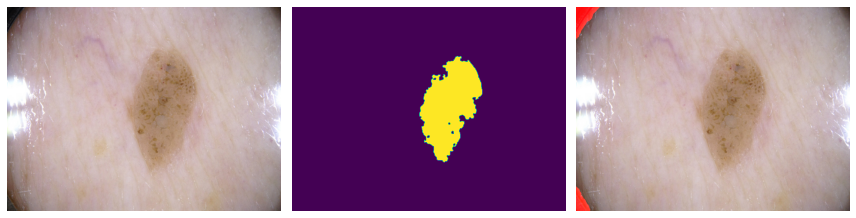

  6%|▌         | 1/17 [00:00<00:12,  1.25it/s]

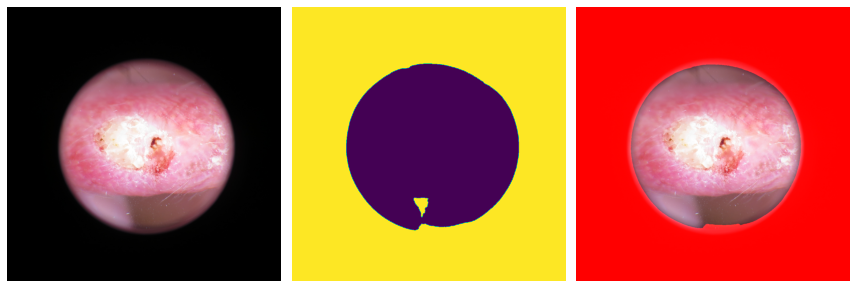

 12%|█▏        | 2/17 [00:01<00:12,  1.22it/s]

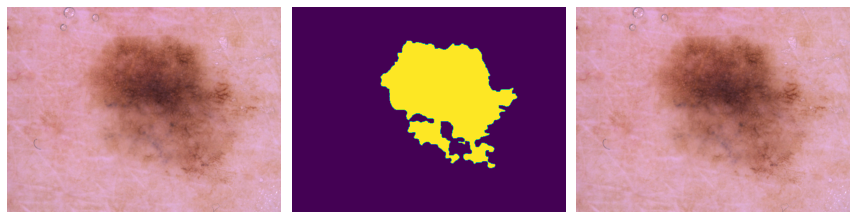

 18%|█▊        | 3/17 [00:02<00:09,  1.53it/s]

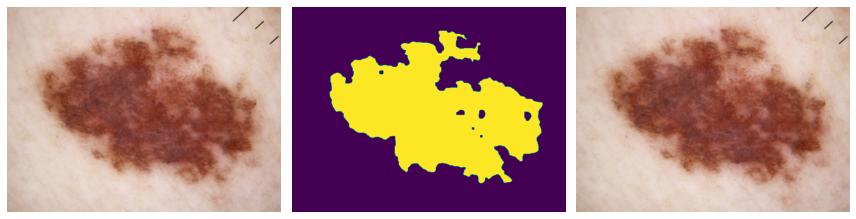

 24%|██▎       | 4/17 [00:02<00:08,  1.50it/s]

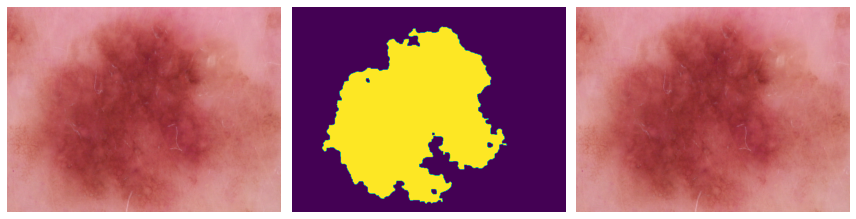

 29%|██▉       | 5/17 [00:03<00:07,  1.65it/s]

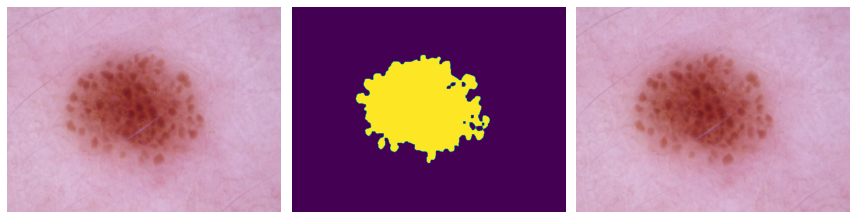

 35%|███▌      | 6/17 [00:03<00:06,  1.81it/s]

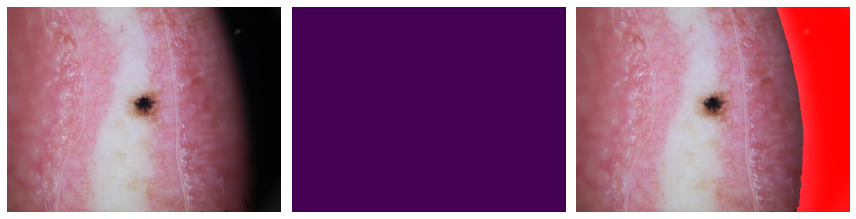

 41%|████      | 7/17 [00:04<00:05,  1.87it/s]

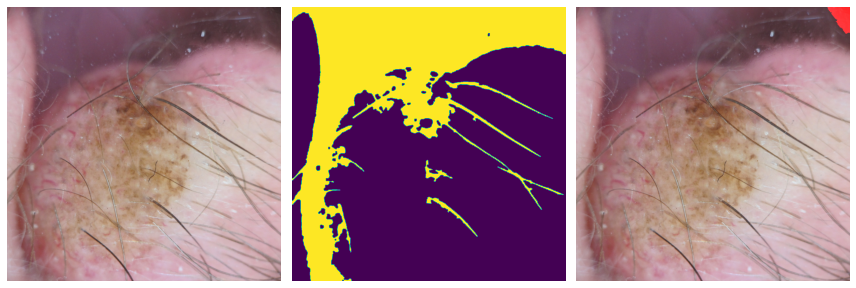

 47%|████▋     | 8/17 [00:05<00:06,  1.41it/s]

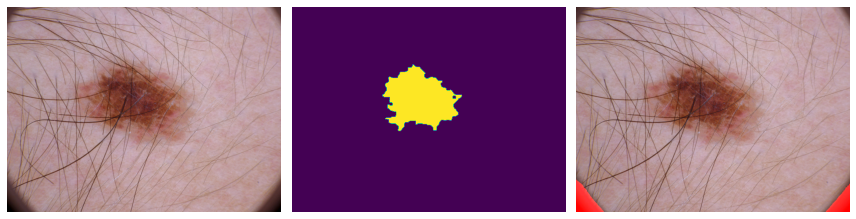

 53%|█████▎    | 9/17 [00:05<00:05,  1.49it/s]

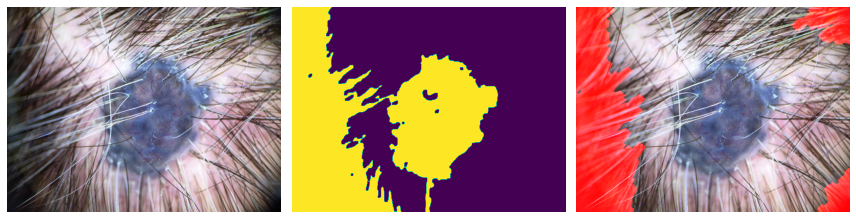

 59%|█████▉    | 10/17 [00:06<00:04,  1.62it/s]

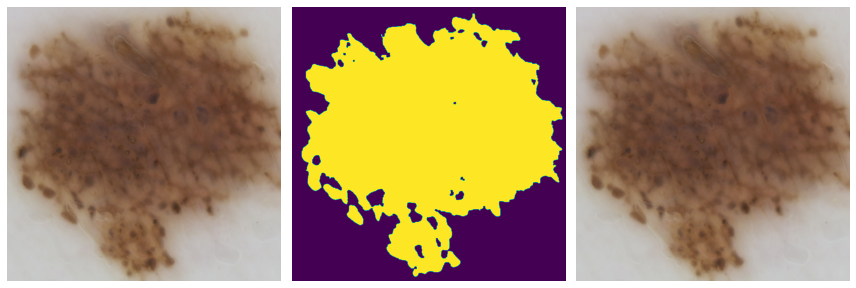

 65%|██████▍   | 11/17 [00:07<00:04,  1.37it/s]

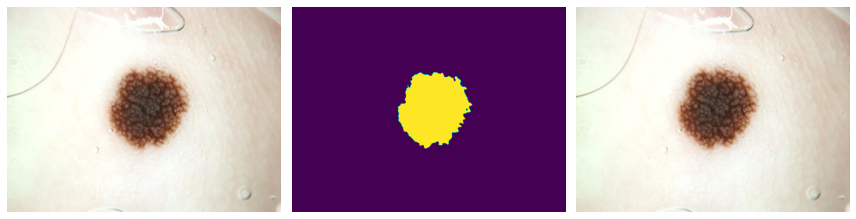

 71%|███████   | 12/17 [00:08<00:03,  1.37it/s]

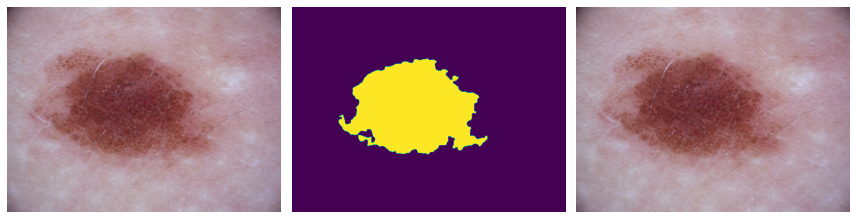

 76%|███████▋  | 13/17 [00:08<00:02,  1.55it/s]

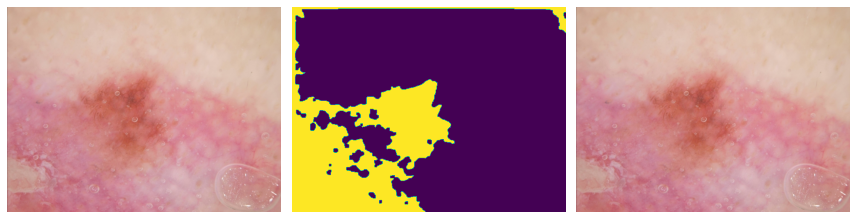

 82%|████████▏ | 14/17 [00:09<00:01,  1.54it/s]

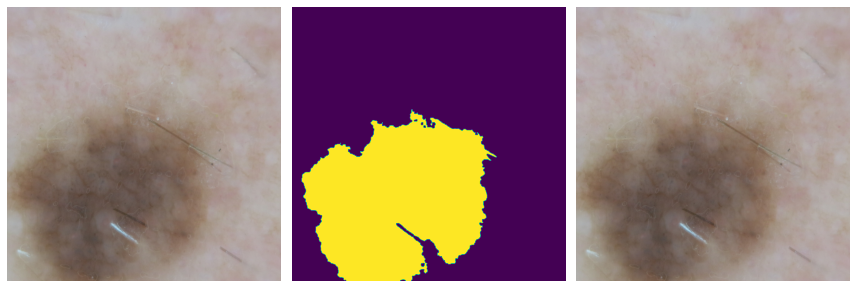

 88%|████████▊ | 15/17 [00:10<00:01,  1.38it/s]

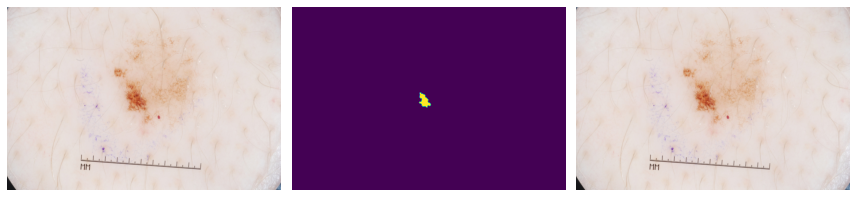

 94%|█████████▍| 16/17 [00:10<00:00,  1.43it/s]

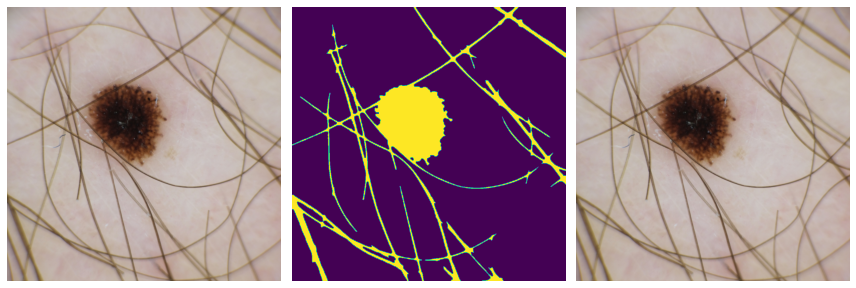

100%|██████████| 17/17 [00:11<00:00,  1.46it/s]


In [12]:
segm = Segment()
for fn in tqdm(list(random_other_img[0:2])+list(random_nevus_img)):
    test_image = cv2.imread(str(fn))
    img_segm = segm.segment(test_image, '', save=False)
    fig, axs = plt.subplots(1,3,figsize=(12, 12))
    test_image_bgr = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
    axs[0].imshow(test_image_bgr)
    axs[1].imshow(img_segm)
    axs[0].axis('off')
    axs[1].axis('off')
    
    r = segm.fov_mask(test_image)
    test_image_masked = test_image_bgr.copy()
    test_image_masked[:,:,0][r>0] = 255
    axs[2].imshow(test_image_masked)
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # plt.imshow(cv2.cvtColor(r, cv2.COLOR_GRAY2RGB))
    # plt.show()
    # break